In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from pathlib import Path

In [3]:
EPOCHS = 20
BATCHES = 32
IMAGE_SIZE = 224
CHANNEL = 3

In [4]:
BASE_PATH = "/kaggle/input/chest-xray-pneumonia/chest_xray"

TRAIN_PATH = Path(os.path.join(BASE_PATH, "train"))
VAL_PATH = Path(os.path.join(BASE_PATH, "val"))
TEST_PATH = Path(os.path.join(BASE_PATH, "test"))

In [5]:
def create_dataset(datapath):
    ds = keras.utils.image_dataset_from_directory(datapath, batch_size=BATCHES, image_size=(IMAGE_SIZE, IMAGE_SIZE))
    return ds

In [6]:
train_ds = create_dataset(TRAIN_PATH)
val_ds = create_dataset(VAL_PATH)
test_ds = create_dataset(TEST_PATH)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [7]:
class_names = train_ds.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [8]:
no_of_classes = len(class_names)
no_of_classes

2

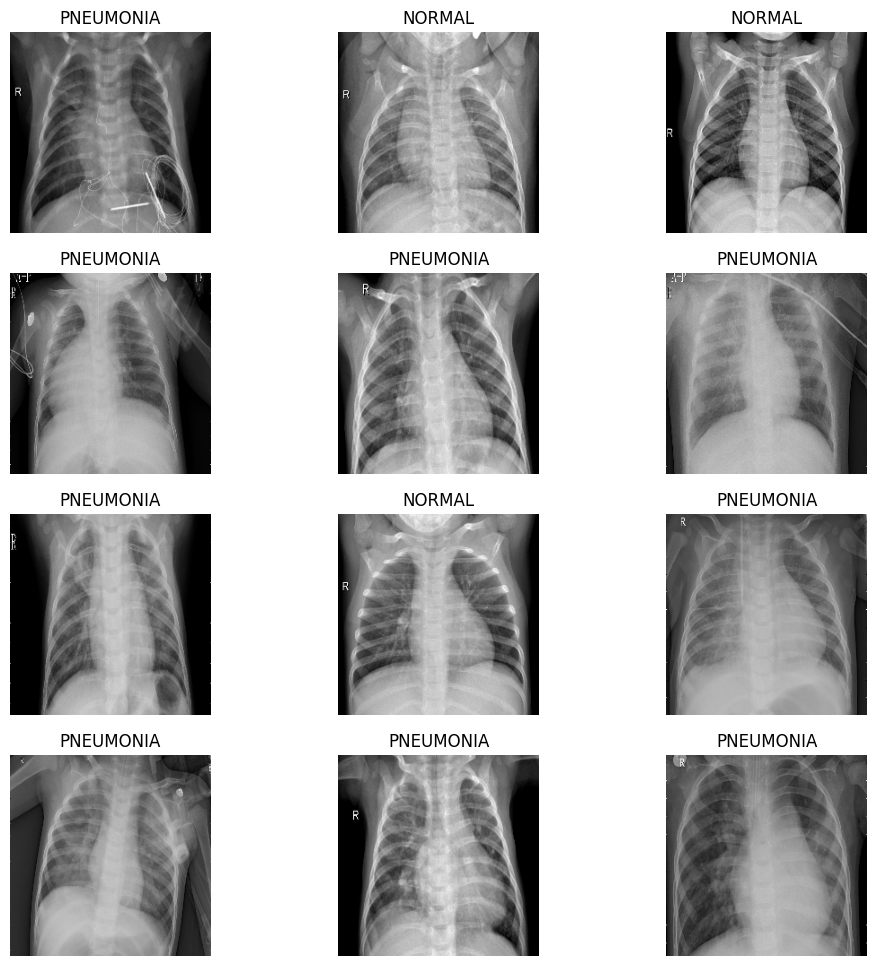

In [9]:
plt.figure(figsize=(12,12))

for images, labels in train_ds.take(1):
    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.imshow(images[i].numpy().astype(int))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
len(train_ds), len(val_ds), len(test_ds)

(163, 1, 20)

In [11]:
#data augmentation layer for training

aug_layer = keras.models.Sequential()

aug_layer.add(keras.layers.RandomFlip())
aug_layer.add(keras.layers.RandomRotation(0.2))

aug_ds = train_ds.map(lambda x, y: (aug_layer(x, training=True), y))

train_ds = train_ds.concatenate(aug_ds)

In [12]:
image_shape = (224, 224, 3)

In [13]:
base_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=image_shape)

for layer in base_model.layers:
    layer.trainable=False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
image_shape = (224, 224, 3)
image = keras.layers.Input(shape=image_shape)
preprocess = keras.layers.Rescaling(scale=(1./255))(image)
x = base_model(preprocess)
avg = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(2, activation="softmax")(avg)
model = keras.Model(inputs=image, outputs=output)

In [15]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.7)
loss = keras.losses.SparseCategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5


I0000 00:00:1732805974.352471     105 service.cc:145] XLA service 0x79007c04b1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732805974.352545     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732805974.352550     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/326 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.4141 - loss: 8.2038   

I0000 00:00:1732805979.954670     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


326/326 ━━━━━━━━━━━━━━━━━━━━ 84s 224ms/step - accuracy: 0.6224 - loss: 38.8892 - val_accuracy: 0.5000 - val_loss: 90.8673
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 65s 199ms/step - accuracy: 0.6847 - loss: 20.8448 - val_accuracy: 0.5000 - val_loss: 19.5644
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 66s 201ms/step - accuracy: 0.7208 - loss: 15.3956 - val_accuracy: 0.5625 - val_loss: 31.9952
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 65s 201ms/step - accuracy: 0.7540 - loss: 9.8736 - val_accuracy: 0.5625 - val_loss: 5.9192
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 65s 200ms/step - accuracy: 0.7584 - loss: 9.3267 - val_accuracy: 0.7500 - val_loss: 6.4356


In [17]:
for layer in base_model.layers:
    layer.trainable=True

In [18]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.7)
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

In [19]:
mc = keras.callbacks.ModelCheckpoint("/kaggle/working/my_model.keras", save_best_only=True)
lr = keras.callbacks.ReduceLROnPlateau(min_lr=0.001)

In [20]:
history = model.fit(train_ds, epochs=30, batch_size=32, verbose=1, validation_data=val_ds, callbacks=[mc, lr])

Epoch 1/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 163s 392ms/step - accuracy: 0.7957 - loss: 5.9075 - val_accuracy: 0.4375 - val_loss: 70.8113 - learning_rate: 0.0100
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 122s 374ms/step - accuracy: 0.8839 - loss: 0.3308 - val_accuracy: 0.5000 - val_loss: 311.0200 - learning_rate: 0.0100
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 122s 375ms/step - accuracy: 0.9147 - loss: 0.2075 - val_accuracy: 0.5000 - val_loss: 1.1184 - learning_rate: 0.0100
Epoch 4/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 123s 378ms/step - accuracy: 0.9378 - loss: 0.1757 - val_accuracy: 0.8125 - val_loss: 0.4692 - learning_rate: 0.0100
Epoch 5/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 118s 363ms/step - accuracy: 0.9398 - loss: 0.1766 - val_accuracy: 0.5625 - val_loss: 1.6973 - learning_rate: 0.0100
Epoch 6/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 118s 362ms/step - accuracy: 0.9380 - loss: 0.1778 - val_accuracy: 0.6875 - val_loss: 0.5052 - learning_rate: 0.0100
Epoch 7/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 120s 367ms/step - acc

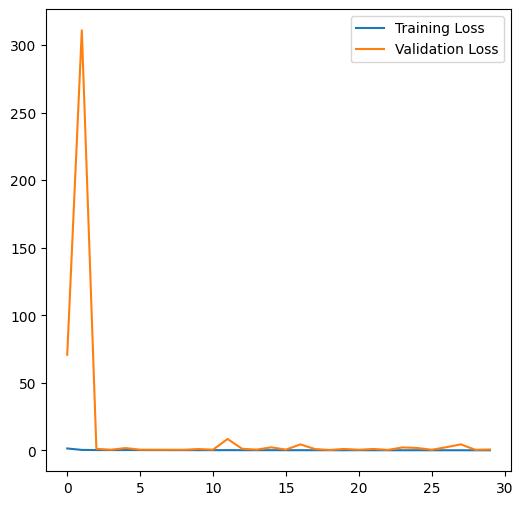

In [21]:
plt.figure(figsize=(6,6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="best")
plt.show()

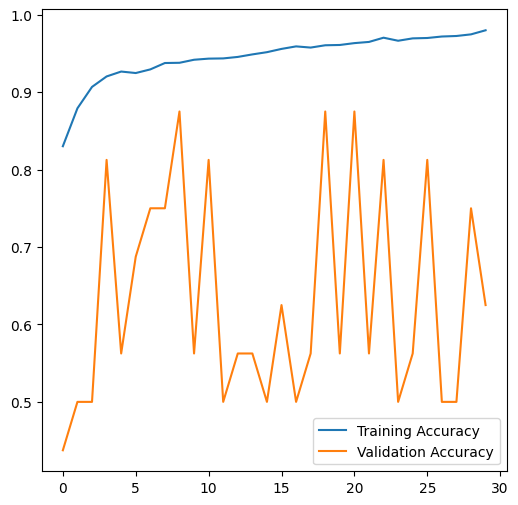

In [22]:
plt.figure(figsize=(6,6))

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="best")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


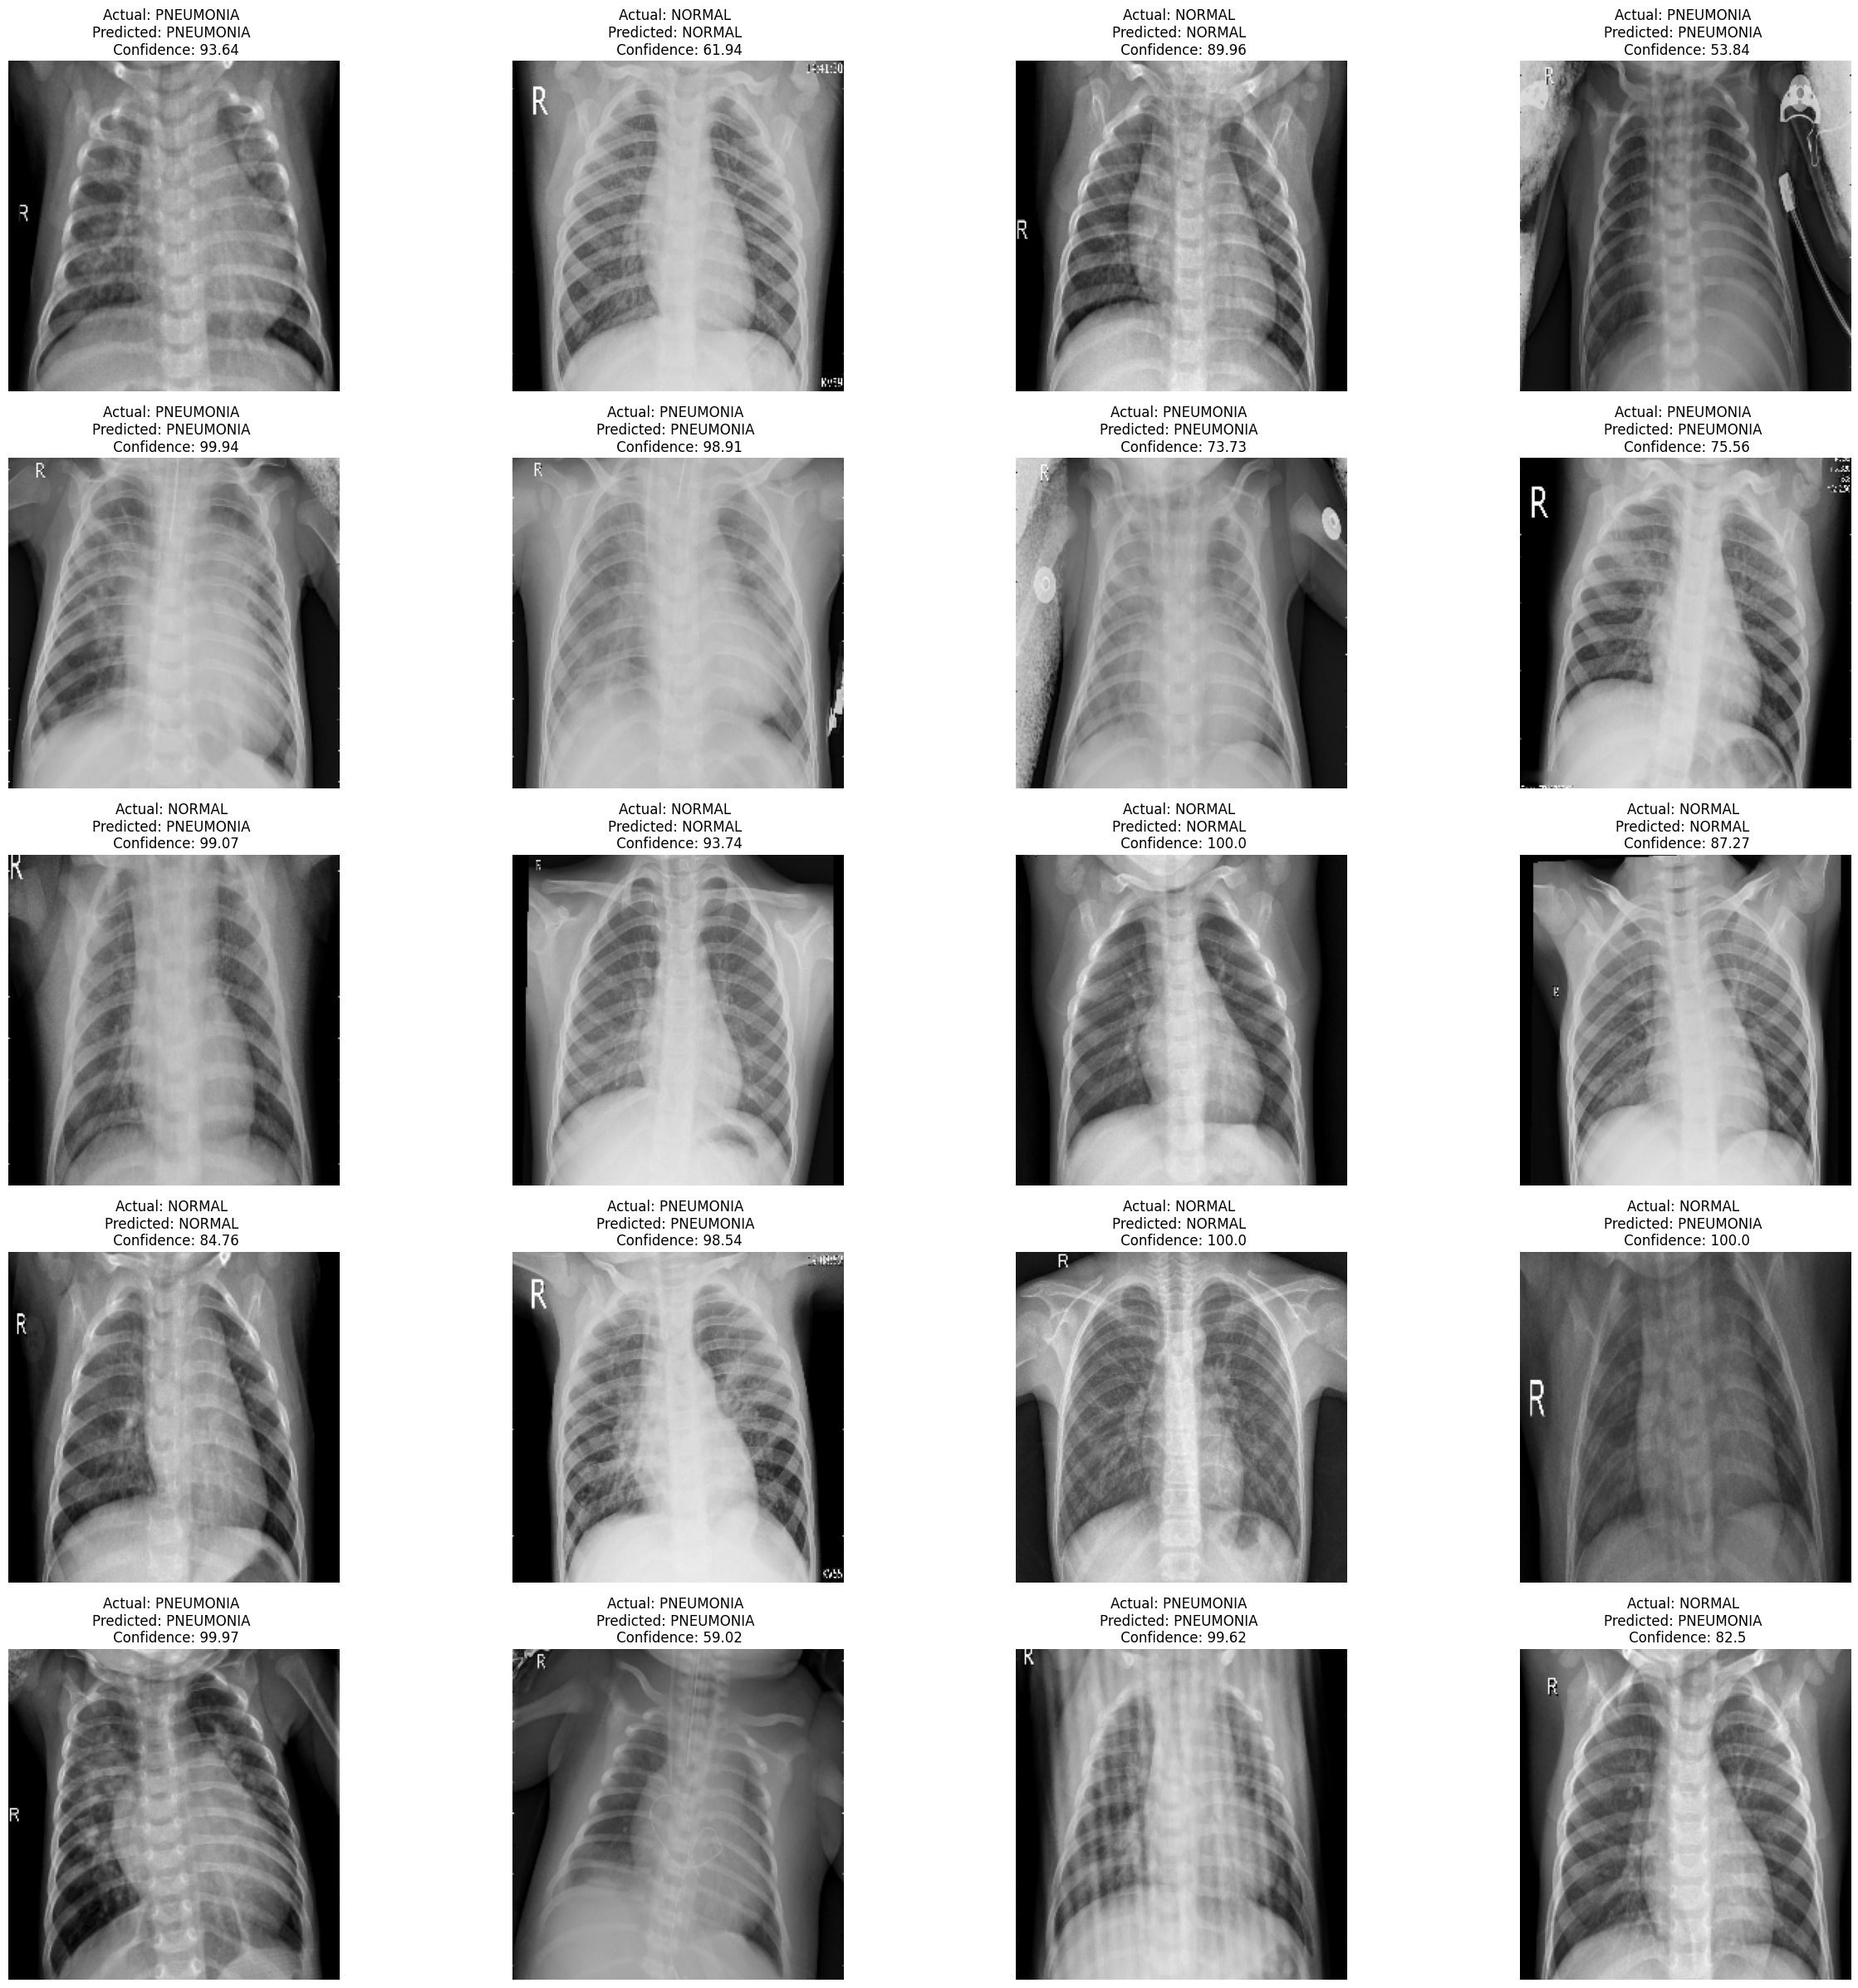

In [23]:
plt.figure(figsize=(30, 30))

for image, label in test_ds.take(1):
    for i in range(20):
        plt.subplot(5, 4, i+1)
        plt.imshow(image[i].numpy().astype(int))
        img_arg = np.expand_dims(image[i], axis=0)
        probas = model.predict(img_arg)
        prediction = class_names[np.argmax(probas[0])]
        confidence = round((np.max(probas[0]) * 100), 2)
        actual = class_names[label[i]]
        plt.title(f"Actual: {actual} \nPredicted: {prediction} \n Confidence: {confidence}")
        plt.axis("off")

In [24]:
test_loss, test_acc = model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.8600 - loss: 0.5127
